## Importing Packages

In [54]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\khadi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [1]:
#Import Needed Packages

import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
from datetime import datetime
import plotly.offline as py
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import ticker
from datetime import datetime, timedelta
%matplotlib inline

##  Loading Data

In [43]:
# Read The Data 
train = pd.read_csv(r"C:\Users\khadi\OneDrive\Desktop\train.tsv",sep='\t')

## Spliting the train data 

In [44]:
X = train.drop(columns=['price'])  # Features
y = train['price'] 

In [45]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.2, random_state=42)


In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186028 entries, 1416089 to 121958
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1186028 non-null  int64  
 1   name               1186028 non-null  object 
 2   item_condition_id  1186028 non-null  int64  
 3   category_name      1180945 non-null  object 
 4   brand_name         679970 non-null   object 
 5   price              1186028 non-null  float64
 6   shipping           1186028 non-null  int64  
 7   item_description   1186025 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 81.4+ MB


#### Overview

In [47]:
train.head() # View The First 5 Rows 

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1416089,1416089,LuLaRoe kids L/XL leggings,3,Kids/Boys (4+)/Bottoms,NaN,15.0,1,Worn once. Still in great condition
1423955,1423955,Bundle 5 Display mannequins,1,Other/Other/Other,NaN,44.0,0,Brand new
403867,403867,LIVING PROOF PERFECT HAIR DAY DRY SHAMPO,1,Beauty/Hair Care/Styling Products,NaN,35.0,0,This listing is for 3 full size bottles of liv...
701974,701974,Palazzo pants,2,Women/Pants/Casual Pants,NaN,19.0,0,Like new adorable black and white palazzo pant...
1124330,1124330,RESERVED FOR Ms Jas PINK BOYSHORTS LARGE,1,Women/Underwear/Panties,PINK,30.0,1,NEW WITH TAGS MORNING SKY SHEER SEAFOAM OLIVE ...


# Cleaning 

In [48]:
train.drop(columns=['train_id'], inplace=True)

### Missing Values

In [69]:
train.isnull().sum(axis=0) #Number of Nulls in each column

name                      0
item_condition_id         0
category_name          5083
brand_name           506058
price                     0
shipping                  0
item_description          3
dtype: int64

- The column with the most null values is **brand_name** : **632682**
- Then, **6327** records have null values in **category_name** column.
- Only **4** items miss their **item_description**

In [75]:
def drop_price_and_cat_missing_values(data):
    data = data.loc[data['price'] != 0].copy()
    data.dropna(subset=['category_name'], inplace=True)
    return data

In [76]:
def imputing(data):
    def mode_func(x):
        return x.mode().iloc[0] if not x.mode().empty else None
    

    # grouped the data by (category_name) then we got the brand_name mode of each group
    brand_name_grouped = data.groupby('category_name')['brand_name']
    grouped = brand_name_grouped.agg(mode_func).reset_index()

    #fill the missing value in each group with the brand_name mode of its group 
    modes = brand_name_grouped.transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    # Fill missing values in 'brand_name' with the calculated modes within each group
    data['brand_name'] = data['brand_name'].fillna(modes)
    return data

In [77]:
def fill_missing_data(data):
    data.brand_name.fillna(value="No Brand", inplace=True)
    data.item_description.fillna(value = "No description yet", inplace = True)
    return data

# create pipeline for drop, imputing and filling

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
drop_transformer = FunctionTransformer(drop_price_and_cat_missing_values, validate=False)
impute_transformer = FunctionTransformer(imputing, validate=False)
fill_missing_transformer = FunctionTransformer(fill_missing_data, validate=False)


data_preprocessing_pipeline = Pipeline([
    ('drop',drop_transformer),
    ('impute', impute_transformer),
    ('fill_missing', fill_missing_transformer)
])

# apply pipline on train data

In [79]:
train = data_preprocessing_pipeline.fit_transform(train)

C:\Users\khadi\AppData\Local\Temp\ipykernel_13868\3525510350.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\khadi\AppData\Local\Temp\ipykernel_13868\3525510350.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\khadi\AppData\Local\Temp\ipykernel_13868\3525510350.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\khadi\AppData\Local\Temp\ipykernel_13868\3525510350.py:11: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\khadi\AppData\Local\Temp\ipykernel_13868\3525510350.py:11: FutureWa

In [80]:
train.isnull().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

In [81]:
train.shape

(1180258, 7)

## Feature Engineering

# Sentiments Score
A score ranging between 0–100% that shows the polarity of the sentence i.e how much is a sentence positive, negative, and neutral. A score of 100% shows total positivity and vice versa. An overall score is given by the compound.

In [82]:
def feature_engineering(data):
    def category_tranformation(category):
        try:
            category, sub_category_1, sub_category_2 = category.split('/')
            return category, sub_category_1, sub_category_2
        except:
            return 'Other', 'Other', 'Other'
    data['main_category'], data['category_sub1'], data['category_sub2'] = zip(*data['category_name'].apply(category_tranformation))
    sia = SentimentIntensityAnalyzer()
    data['compound_sentiment_score'] = data['item_description'].apply(lambda x: sia.polarity_scores(x)['compound'])
    # Calculate and store item_description length (desc_len)
    data['desc_len'] = data['item_description'].apply(lambda x: len(x))
    # Calculate and store count of words in item_description (desc_cnt)
    data['desc_cnt'] = data['item_description'].apply(lambda x: len(x.split()))
    return data


In [83]:
train = feature_engineering(train)

In [84]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1180258 entries, 1416089 to 121958
Data columns (total 13 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   name                      1180258 non-null  object 
 1   item_condition_id         1180258 non-null  int64  
 2   category_name             1180258 non-null  object 
 3   brand_name                1180258 non-null  object 
 4   price                     1180258 non-null  float64
 5   shipping                  1180258 non-null  int64  
 6   item_description          1180258 non-null  object 
 7   main_category             1180258 non-null  object 
 8   category_sub1             1180258 non-null  object 
 9   category_sub2             1180258 non-null  object 
 10  compound_sentiment_score  1180258 non-null  float64
 11  desc_len                  1180258 non-null  int64  
 12  desc_cnt                  1180258 non-null  int64  
dtypes: float64(2), int64(4

C:\Users\khadi\AppData\Local\Temp\ipykernel_13868\1464813393.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



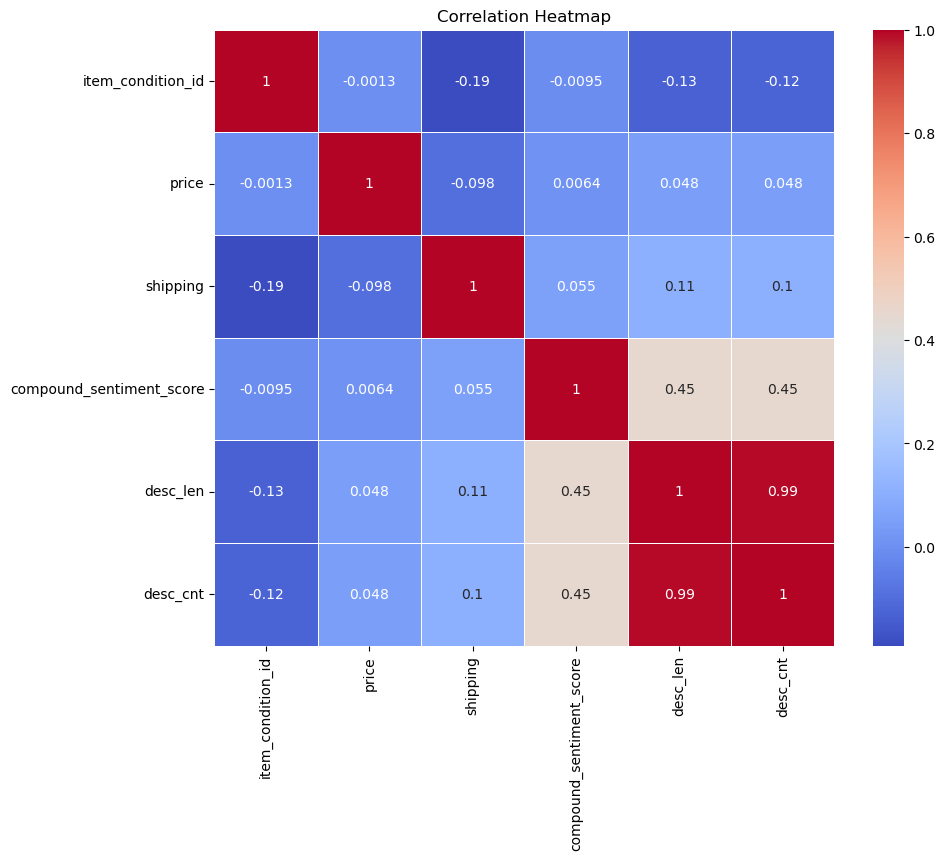

In [85]:
correlation_matrix = train.corr()
plt.figure(figsize=(10, 8))  # Set the figure size (optional)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Spliting the data to X and y

In [ ]:
X_train = train.drop(columns=['price'])  # Features
y_train = train['price'] 
X_test =  test.drop(columns=['price'])
y_test =  test['price'] 

# Encoding and ColumnTransformer

applied ColumnTransformer with transformers — Counvectorizer, TfidfVectorizer, and Normalizer to transform the text and numerical features into a single feature space.

CountVectorizer and TfidfVectorizer are both text vectorization techniques commonly used in natural language processing (NLP) and machine learning for converting text data into numerical feature vectors

Example:

Document 1: "I love programming."
Document 2: "Programming is fun."
Document 3: "I enjoy coding."

>Using CountVectorizer:

CountVectorizer will convert this corpus into a matrix of word counts. Here's what it would look like:

Vocabulary: ["I", "love", "programming", "is", "fun", "enjoy", "coding"]
Document 1: [1, 1, 1, 0, 0, 0, 0]
Document 2: [0, 0, 1, 1, 1, 0, 0]
Document 3: [1, 0, 0, 0, 0, 1, 1]

>Using TfidfVectorizer:

TfidfVectorizer takes into account not just word counts but also the importance of each word in the corpus. It calculates TF-IDF scores for each word in each document:

Vocabulary: ["I", "love", "programming", "is", "fun", "enjoy", "coding"]
Document 1: [0.59, 0.81, 0.5, 0, 0, 0, 0]
Document 2: [0, 0, 0.5, 0.81, 0.81, 0, 0]
Document 3: [0.59, 0, 0, 0, 0, 0.81, 0.81]

In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer
def encoding(data):
  name_vec = CountVectorizer(
    ngram_range=(1, 2), max_features=150000, 
    stop_words=['why', 'x', 'w', 's', 'e', 'ty', 'wgf'],
    token_pattern = r'(?u)\w+|[^\w\s]',
  )
  desc_vec = TfidfVectorizer(
    ngram_range=(1, 3), max_features=150000, token_pattern = r'(?u)\w+|[^\w\s]',
  )
  bname_vec = CountVectorizer( ngram_range = (1, 2))
  cat_vec = CountVectorizer( token_pattern='.+')
  numeric_features = [
  'item_condition_id', 'shipping' , 'desc_cnt', 'desc_len','compound_sentiment_score'
  ]
  col_transformer = ColumnTransformer(
    transformers=[
      ('numerical', Normalizer(), numeric_features),
      ('name', name_vec, 'name'),
      ('brand_name', bname_vec, 'brand_name'),
      ('item_description', desc_vec, 'item_description'),
      ('main_category', cat_vec, 'main_category'),
      ('category_sub1', cat_vec, 'category_sub1'),
      ('category_sub2', cat_vec, 'category_sub2'),
    ]
  )
  vectorizer = col_transformer.fit(data)
  train_vec = vectorizer.transform(data)
  return train_vec

In [88]:
X_train = encoding(X_train)

<1180258x308394 sparse matrix of type '<class 'numpy.float64'>'
	with 87006529 stored elements in Compressed Sparse Row format>

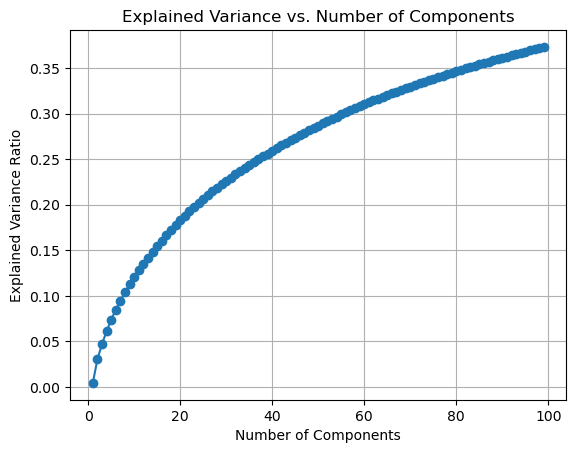

In [91]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Initialize TruncatedSVD
svd = TruncatedSVD()

# List to store explained variance ratios
explained_variances = []

# Try different numbers of components
components_range = range(1, 100)  # Adjust the range as needed
for n_components in components_range:
    svd.n_components = n_components
    svd.fit(X_train)  # Use your preprocessed data here
    explained_variances.append(svd.explained_variance_ratio_.sum())

# Plot explained variance ratios
plt.plot(components_range, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()


TruncatedSVD as an alternative for dimensionality reduction when working with sparse data
# your_desired_number_of_components = value from the appove chart 

In [92]:
svd = TruncatedSVD(n_components=30)  # Set the number of components you want
X_train = svd.fit(X_train)

# create pipline for feature engineering , encoding and 
حاليا اعملي سكيب لهاد البايب لاين بعمله بعدين

In [87]:
# feature_transformer = FunctionTransformer(feature_engineering, validate=False)
# encoding_transformer = FunctionTransformer(encoding, validate=False)
# svd = TruncatedSVD(n_components=your_desired_number_of_components)  # Set the number of components you want
# svd_transformer = svd.fit(data_preprocessed)

# feature_encoding_preprocessing_with_pca_pipeline = Pipeline([
#     ('feature',feature_transformer),
#     ('encoding', encoding_transformer),
#     ('pca', svd_transformer),
# ])
# train = feature_encoding_preprocessing_with_pca_pipeline.fit_transform(train)

# Modeling

In [86]:
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
params = { 
  'objective': 'regression', 'learning_rate': 0.5, 'max_depth': 8,
  'n_estimators': 600, 'num_leaves': 120
}

estimators = [
  ('lr', Ridge(alpha=7)),
  ('svr', LGBMRegressor(**params, random_state=42)),
  ('lrr', Ridge(alpha=10)),
]

reg = StackingRegressor(
  estimators=estimators,
  final_estimator=Ridge(alpha=7),
  verbose=10, cv=3
)
reg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1106.975223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2753478
[LightGBM] [Info] Number of data points in the train set: 1475343, number of used features: 233683
[LightGBM] [Info] Start training from score 26.758899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 615.805929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2673021
[LightGBM] [Info] Number of data points in the train set: 983562, number of used features: 191471
[LightGBM] [Info] Start training from score 26.771729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 32.0min remaining:    0.0s


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 610.491828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2670752
[LightGBM] [Info] Number of data points in the train set: 983562, number of used features: 191374
[LightGBM] [Info] Start training from score 26.735838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 63.1min remaining:    0.0s


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 616.140394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2670021
[LightGBM] [Info] Number of data points in the train set: 983562, number of used features: 191431
[LightGBM] [Info] Start training from score 26.769130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 94.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 94.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min finished


StackingRegressor(cv=3,
                  estimators=[('lr', Ridge(alpha=7)),
                              ('svr',
                               LGBMRegressor(learning_rate=0.5, max_depth=8,
                                             n_estimators=600, num_leaves=120,
                                             objective='regression',
                                             random_state=42)),
                              ('lrr', Ridge(alpha=10))],
                  final_estimator=Ridge(alpha=7), verbose=10)

In [105]:
from sklearn.metrics import r2_score
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

R2: 0.7103782423133129
